In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csv-data/2-VLSP2018-SA-Restaurant-dev.csv
/kaggle/input/csv-data/3-VLSP2018-SA-Hotel-test.csv
/kaggle/input/csv-data/1-VLSP2018-SA-Restaurant-train.csv
/kaggle/input/csv-data/2-VLSP2018-SA-Hotel-dev.csv
/kaggle/input/csv-data/3-VLSP2018-SA-Restaurant-test.csv
/kaggle/input/csv-data/1-VLSP2018-SA-Hotel-train.csv
/kaggle/input/modelas/tensorflow2/default/1/vietnamese_processor.py
/kaggle/input/modelas/tensorflow2/default/1/acs_model.py
/kaggle/input/modelas/tensorflow2/default/1/helper.py
/kaggle/input/modelas/tensorflow2/default/1/vlsp2018_processor.py


In [5]:
from vlsp2018_processor import VLSP2018Parser

ModuleNotFoundError: No module named 'vlsp2018_processor'

In [3]:
import sys
import tensorflow as tf
sys.path.append('..')
tf.__version__

'2.16.1'

In [4]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())

Using GPU: /device:GPU:0


In [33]:
TRAIN_PATH = '/kaggle/input/csv-data/1-VLSP2018-SA-Hotel-train.csv'
VAL_PATH = '/kaggle/input/csv-data/2-VLSP2018-SA-Hotel-dev.csv'
TEST_PATH = '/kaggle/input/csv-data/2-VLSP2018-SA-Hotel-dev.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'Hotel-v2' # Multitask model on Hotel domain
MAX_LENGTH = 256
BATCH_SIZE = 128
EPOCHS = 20

In [77]:
sys.path.append('/kaggle/input/modelas/tensorflow2/default/1')

In [23]:
from vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATUR

In [27]:
!git clone https://github.com/vncorenlp/VnCoreNLP.git

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 259 (delta 17), reused 33 (delta 11), pack-reused 212 (from 1)
Receiving objects: 100% (259/259), 237.79 MiB | 47.58 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [38]:
vncorepath=os.path.abspath('VnCoreNLP')
vncorepath

'/kaggle/working/VnCoreNLP'

In [44]:
from vietnamese_processor import VietnameseTextPreprocessor
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processor/VnCoreNLP', extra_teencodes={
    'khách sạn': ['ks'], 'nhà hàng': ['nhahang'], 'nhân viên': ['nv'],
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

2024-11-06 05.14.43 INFO VnCoreNLPServer - Using annotators: wseg
2024-11-06 05:14:43 INFO  WordSegmenter:24 - Loading Word Segmentation model
2024-11-06 05.14.43 INFO VnCoreNLPServer - VnCoreNLPServer is listening on http://127.0.0.1:43069
2024-11-06 05.14.43 INFO log - Logging initialized @730ms to org.eclipse.jetty.util.log.Slf4jLog
2024-11-06 05.14.43 INFO EmbeddedJettyServer - == Spark has ignited ...
2024-11-06 05.14.43 INFO EmbeddedJettyServer - >> Listening on 127.0.0.1:43069
2024-11-06 05.14.43 INFO Server - jetty-9.4.z-SNAPSHOT, build timestamp: 2017-11-21T21:27:37Z, git hash: 82b8fb23f757335bb3329d540ce37a2a2615f0a8
2024-11-06 05.14.43 INFO session - DefaultSessionIdManager workerName=node0
2024-11-06 05.14.43 INFO session - No SessionScavenger set, using defaults
2024-11-06 05.14.43 INFO session - Scavenging every 660000ms
2024-11-06 05.14.43 INFO AbstractConnector - Started ServerConnector@36d7eba1{HTTP/1.1,[http/1.1]}{127.0.0.1:43069}
2024-11-06 05.14.43 INFO Server - Sta

In [31]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [45]:
preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
preprocessed_datasets.save_to_disk('kaggle/working/preprocessed_hotel')
display(preprocessed_datasets)


[INFO] Preprocessing and tokenizing text data...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFOR

In [46]:
pd.DataFrame({
     'raw_datasets': raw_datasets['train']['Review'][1480:1490],
     'encoded_input_ids': preprocessed_datasets['train']['input_ids'][1480:1490],
     'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(1480, 1490)]
 })

,raw_datasets,encoded_input_ids,decoded_input_ids
0,Nhan viên phục vụ chu đáo Tuy chuyến du lịch c...,"[0, 650, 533, 5655, 2442, 550, 388, 7, 70, 66,...",<s> nhân_viên phục_vụ chu_đáo tuy chuyến du_lị...
1,"Bãi biển đẹp - Phục vụ tốt- Thức ăn ngon, giá ...","[0, 1162, 262, 258, 533, 167, 1849, 1325, 3401...",<s> bãi biển đẹp phục_vụ tốt thức_ăn ngon giá_...
2,Phòng nằm gần biển đẹp Phục vụ phòng t...,"[0, 292, 339, 124, 262, 258, 533, 292, 167, 58...",<s> phòng nằm gần biển đẹp phục_vụ phòng tốt d...
3,Nhân viên chuyên nghiệp tuyệt Khách sạn nằm ở ...,"[0, 650, 1564, 3518, 1299, 339, 25, 442, 9756,...",<s> nhân_viên chuyên_nghiệp tuyệt khách_sạn nằ...
4,Gia đình mình đã có 4 ngày 3 đêm lưu trú tại C...,"[0, 161, 68, 14, 10, 163, 43, 107, 396, 6567, ...",<s> gia_đình mình đã có 4 ngày 3 đêm lưu_trú t...
5,"Tôi ở đây 3 ngày 2 đêm, khách sạn không đúng v...","[0, 70, 25, 97, 107, 43, 76, 396, 1299, 17, 28...",<s> tôi ở đây 3 ngày 2 đêm khách_sạn không đún...
6,"Resort đẹp, Nhân viên phục vụ tận tình. Mình r...","[0, 9823, 258, 650, 533, 9787, 68, 59, 2273, 2...",<s> resort đẹp nhân_viên phục_vụ tận_tình mình...
7,Đây là lần đầu tiên chúng tôi đến Phú Quốc. Nh...,"[0, 97, 8, 101, 191, 283, 30, 56407, 3705, 595...",<s> đây là lần đầu_tiên chúng_tôi đến phú_quốc...
8,Tuy chuyến du lịch của tôi chỉ kéo dài có 3 ng...,"[0, 2442, 550, 388, 7, 70, 66, 832, 10, 107, 4...",<s> tuy chuyến du_lịch của tôi chỉ kéo_dài có ...
9,Bình Minh Resort Cable Car Vũng Tàu (KDL Cáp T...,"[0, 14872, 9823, 1395, 22820, 26283, 44439, 59...",<s> bình_minh resort cable car vũng_tàu khu cá...


In [117]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('/kaggle/working/kaggle/working/preprocessed_hotel')
preprocessed_datasets = VLSP2018Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets

[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [118]:
print('Aspect#Category,Polarity in One-hot form of the first review:')
example_onehot = preprocessed_datasets['train'][0]['FlattenOneHotLabels']
np.array(example_onehot).reshape(-1, 4)

Aspect#Category,Polarity in One-hot form of the first review:


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [122]:
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(ASPECT_CATEGORY_NAMES)

['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL']


In [123]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [125]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True, # You may obtain HIGHER metrics on the test set with longer training time if you set this to False
    # Because after some experiments, I found that even with higher val_loss, it still results in better metric reports on the test set. 
    # This maybe because the training set and the test set have more similarities than the validation data.
    # But I think this is not fair, as we already have prior knowledge about the test set and we modified our training based on the performance on this set. 
    # In real-world, we should only modify our training based on the performance on the validation data
    verbose = 1
)

In [120]:
def plot_training_history(history, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    plt.plot(history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
    plt.plot(history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss',fontsize=14)
    plt.title('Loss', fontsize=15)
    plt.legend(loc='best')
    plt.show()

In [126]:
%%time
from acs_model import VLSP2018MultiTask
model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)

history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


W0000 00:00:1730879815.608542    3002 assert_op.cc:38] Ignoring Assert operator Hotel-v2_1/tf_roberta_model_8/roberta/embeddings/assert_less/Assert/Assert


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - loss: 0.4804

W0000 00:00:1730879843.355939    3003 assert_op.cc:38] Ignoring Assert operator Hotel-v2_1/tf_roberta_model_8/roberta/embeddings/assert_less/Assert/Assert


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4765   

W0000 00:00:1730879866.860356    3001 assert_op.cc:38] Ignoring Assert operator Hotel-v2_1/tf_roberta_model_8/roberta/embeddings/assert_less/Assert/Assert
W0000 00:00:1730879883.019385    3001 assert_op.cc:38] Ignoring Assert operator Hotel-v2_1/tf_roberta_model_8/roberta/embeddings/assert_less/Assert/Assert


24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.4730 - val_loss: 0.2288
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.2151 - val_loss: 0.1712
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.1837 - val_loss: 0.1626
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.1776 - val_loss: 0.1575
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.1728 - val_loss: 0.1535
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.1709 - val_loss: 0.1511
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.1673 - val_loss: 0.1496
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.1672 - val_loss: 0.1489
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.1663 - val_loss: 0.1484
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.1642 - val_loss: 0.1480
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.1661 - val_loss: 0.1478
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.1649 - val_loss: 0.1473

TypeError: Model.save_weights() got an unexpected keyword argument 'save_format'

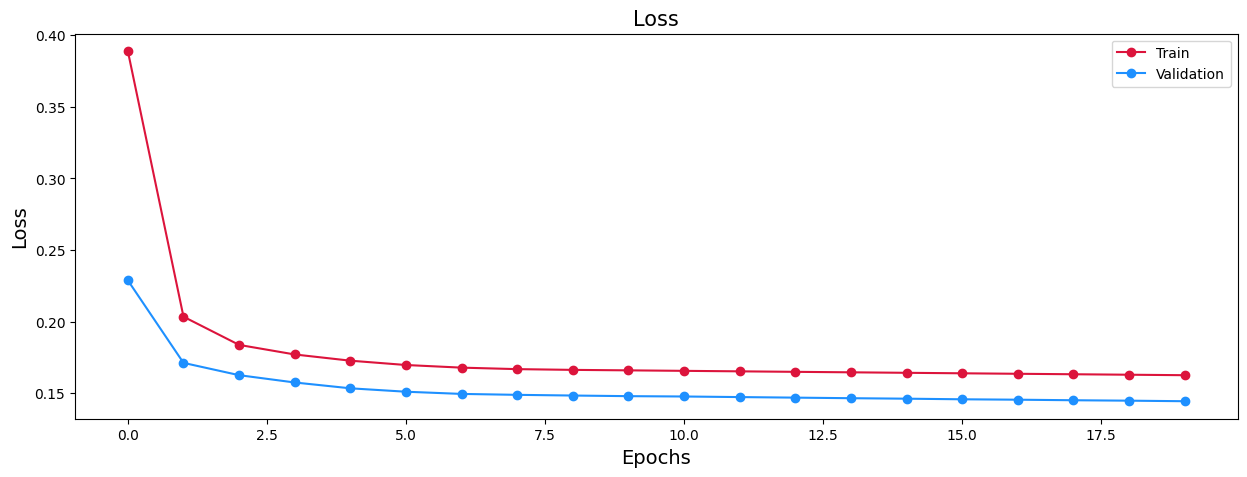

In [128]:
plot_training_history(history)

In [141]:
import os

# Directory where you want to save the model weights
weights_dir = './weights/Hotel-v1/'

# Check if the directory exists, if not, create it
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Now save the model weights
model.save_weights(f'{weights_dir}/Hotel-v1.weights.h5')

'/kaggle/working/Hotel-v1.weights.h5'

In [134]:
pip install dropbox

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 13.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [152]:
import dropbox

DROPBOX_ACCESS_TOKEN = 'sl.CANhp0xB1DXHbmjQcrGirnR80cJKw7JZpcXt285avHX69sGX5PgZWVNmR0RHIsv_IG2rQm6MmpsFA_N6N6G7O7eyKpIbf6VnOvflDqSb715-sRanu3sXP2uKW-1tD_wrpyy5PlW8ChFtk3iOfS1JM8g'
dbx = dropbox.Dropbox(DROPBOX_ACCESS_TOKEN)

file_weight_path = '/kaggle/working/weights/Hotel-v1/Hotel-v1.weights.h5'
dropbox_destination_path = f'/aspect_model/weights.h5'

with open(file_weight_path, 'rb') as f:
    dbx.files_upload(f.read(), dropbox_destination_path, mute=True)

print(f"File '{file_weight_path}' uploaded successfully to Dropbox at '{dropbox_destination_path}'.")

File '/kaggle/working/weights/Hotel-v1/Hotel-v1.weights.h5' uploaded successfully to Dropbox at '/aspect_model/weights.h5'.


In [155]:
from acs_model import VLSP2018MultiTask
reloaded_model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)
reloaded_model.load_weights(f'/kaggle/working/weights/Hotel-v1/Hotel-v1.weights.h5') # Reload the Model
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.5795


0.5794721245765686